In [1]:
import uns
from uns import training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

chrisv on Lubuntu


## Pick a name for the new model

In [2]:
modelname = '901'
# ===================
modelcolumn = 'model_' + modelname # so we don't overwrite img or subject
if modelname in training.columns:
    print('!!! Model exists update')
else:
    print('New model')

New model


## Choose what to exclude

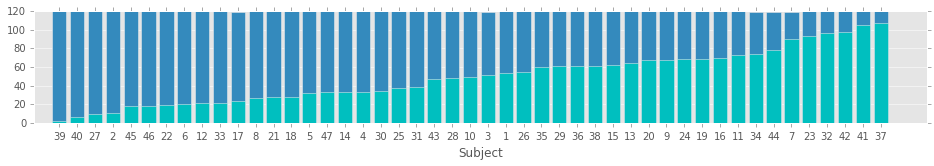

In [4]:
D = np.array([[subject, len(images), np.sum(images['hasmask'])] for subject, images in training.groupby(by='subject')])

sortidx = np.argsort(D[:,2])
SD = D[sortidx,:]
N = len(subject)
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,2))
ax.bar(D[:,0], SD[:,1])
ax.bar(D[:,0], SD[:,2], color='C')

ax.set_xticks(D[:,0]+0.4)
ax.set_xticklabels(D[sortidx,0])
a=ax.set_xlabel('Subject')

In [37]:
## Reset model selections
training[modelcolumn] = 'train'

## Skip specific subjects
minimum_mask_count = 12
subject_mask = training.loc[training.hasmask,['subject','img']].groupby(by='subject').size()
skip_subjects = subject_mask[subject_mask<minimum_mask_count].index

idx = [row in skip_subjects for row in training['subject'].values]
training.ix[idx,modelcolumn] = 'skip'

## Decide on how to choose between train/validate
validate_fraction = 0.2

# Example: Pick at random across subjects
# x = training[training[modelcolumn]=='train'].index.values
# validate_idx = np.random.choice(x,int(len(x)*validate_fraction), replace=False)

# Example: Pick subjects at random
subjects = [s for s in np.arange(47)+1 if s not in skip_subjects]

validate_subjects = np.random.choice(subjects,int(len(subjects)*validate_fraction), replace=False)
validate_idx = [subject in validate_subjects for subject in training['subject'].values]
training.ix[validate_idx, modelcolumn] = 'validate'

## Check distribution of train/validate masks
trainvalidateskip = training.groupby(by=[modelcolumn,'hasmask']).size()

counts = trainvalidateskip.values.reshape(3,-1)

for g, mask, empty in zip(trainvalidateskip.index.levels[0].values, counts[:,0], counts[:,1]):
    print('{:s} {:d}/{:d} empty or {:.3f}'.format(g, mask, mask+empty, mask/(mask+empty)))

totalsum = np.sum(counts, axis=0)
notskip = np.sum(counts[1:,:], axis=0)
print('{:s} {:d}/{:d} empty or {:.3f}'.format('total', totalsum[0], sum(totalsum), totalsum[0]/(sum(totalsum)) ))
print('{:s} {:d}/{:d} empty or {:.3f}'.format('excluding skipped', notskip[0], sum(notskip), notskip[0]/(sum(notskip))))
      

skip 452/480 empty or 0.942
train 2294/4196 empty or 0.547
validate 567/959 empty or 0.591
total 3313/5635 empty or 0.588
excluding skipped 2861/5155 empty or 0.555


In [49]:
modelcolumn = 'test'
validate_fraction = 0.2
samples = 200
counts = np.empty((samples, 3, 2))
for i in range(samples):
    training[modelcolumn] = 'train'

    ## Skip specific subjects
    minimum_mask_count = 12
    subject_mask = training.loc[training.hasmask,['subject','img']].groupby(by='subject').size()
    skip_subjects = subject_mask[subject_mask<minimum_mask_count].index

    idx = [row in skip_subjects for row in training['subject'].values]
    training.ix[idx,modelcolumn] = 'skip'

    ## Decide on how to choose between train/validate



    subjects = [s for s in np.arange(47)+1 if s not in skip_subjects]
    validate_subjects = np.random.choice(subjects,int(len(subjects)*validate_fraction), replace=False)
    validate_idx = [subject in validate_subjects for subject in training['subject'].values]
    training.ix[validate_idx, modelcolumn] = 'validate'

    ## Check distribution of train/validate masks
    trainvalidateskip = training.groupby(by=[modelcolumn,'hasmask']).size()

    counts[i,:,:] = trainvalidateskip.values.reshape(3,-1)
   
    

(array([  2.,   1.,   3.,   3.,   5.,  13.,  13.,  18.,  17.,  11.,  21.,
         24.,  15.,  18.,   9.,  11.,   3.,   5.,   6.,   2.]),
 array([ 0.5107245 ,  0.51490705,  0.51908961,  0.52327216,  0.52745472,
         0.53163727,  0.53581983,  0.54000238,  0.54418494,  0.54836749,
         0.55255005,  0.5567326 ,  0.56091516,  0.56509771,  0.56928027,
         0.57346282,  0.57764538,  0.58182793,  0.58601049,  0.59019304,
         0.5943756 ]),
 <a list of 20 Patch objects>)

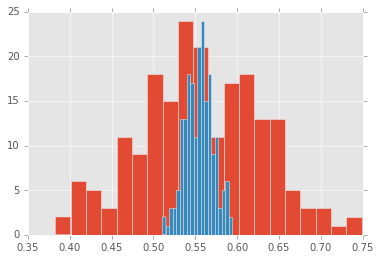

In [54]:
# Calculate fractions:
validate_empty_rate = [c[2,0]/sum(c[2,:]) for c in counts]
validate_masks = [c[2,0] for c in counts]
train_empty_rate = [c[1,0]/sum(c[1,:]) for c in counts]
train_masks = [c[1,0] for c in counts]

fig, ax = plt.subplots()
ax.hist(validate_empty_rate, bins=20, label='validate')
ax.hist(train_empty_rate, bins=20, label='train')

In [43]:
for c in counts:
    print(c)

[452  28]
[2294 1902]
[567 392]


In [7]:
    for g, mask, empty in zip(trainvalidateskip.index.levels[0].values, counts[:,0], counts[:,1]):
        print('{:s} {:d}/{:d} empty or {:.3f}'.format(g, mask, mask+empty, mask/(mask+empty)))

    totalsum = np.sum(counts, axis=0)
    notskip = np.sum(counts[1:,:], axis=0)
    print('{:s} {:d}/{:d} empty or {:.3f}'.format('total', totalsum[0], sum(totalsum), totalsum[0]/(sum(totalsum)) ))
    print('{:s} {:d}/{:d} empty or {:.3f}'.format('excluding skipped', notskip[0], sum(notskip), notskip[0]/(sum(notskip))))
      

## Finally, save to msgpack format

In [236]:
training.to_msgpack('training.bin')